In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
from torch.utils.data import DataLoader #my input


In [7]:
# Define transformations for training and validation datasets
train_img_norm = transforms.Compose([
    transforms.ToTensor()
])

val_img_norm = transforms.Compose([
    transforms.ToTensor()
])

# Paths to the datasets
path_to_train_dataset = "ImgDataset/train"
path_to_val_dataset = "ImgDataset/valid"

# Load the datasets
train_dataset = datasets.ImageFolder(root=path_to_train_dataset, transform=train_img_norm)
val_dataset = datasets.ImageFolder(root=path_to_val_dataset, transform=val_img_norm)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# Function to calculate mean and std
def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    nb_samples = 0.0
    
    for data in loader:
        images, _ = data
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        nb_samples += batch_samples
    
    mean /= nb_samples
    std /= nb_samples
    
    return mean, std

# Calculate mean and std for training dataset
train_mean, train_std = calculate_mean_std(train_loader)
print(f'Training Mean: {train_mean}')
print(f'Training Std: {train_std}')

# Calculate mean and std for validation dataset
val_mean, val_std = calculate_mean_std(val_loader)
print(f'Validation Mean: {val_mean}')
print(f'Validation Std: {val_std}')

Training Mean: tensor([0.4188, 0.4286, 0.3028])
Training Std: tensor([0.2371, 0.2174, 0.2267])
Validation Mean: tensor([0.4262, 0.4355, 0.3066])
Validation Std: tensor([0.2348, 0.2160, 0.2270])


In [8]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([mean], [std])
        transforms.Normalize([0.4187, 0.4286, 0.3028], [0.2371, 0.2174, 0.2267])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.4262, 0.4355, 0.3066], [0.2347, 0.2160, 0.2270])
    ]),
}



In [9]:
# Define the data directory
data_dir = "ImgDataset"

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 1275
     Root location: ImgDataset/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.4187, 0.4286, 0.3028], std=[0.2371, 0.2174, 0.2267])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 364
     Root location: ImgDataset/valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.4262, 0.4355, 0.3066], std=[0.2347, 0.216, 0.227])
            )}

In [10]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 1275, 'valid': 364}


['daisy', 'dandelion']

In [11]:
# Load the pre-trained ResNet-18 model with updated syntax
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters

# Move the model to the GPU if available
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/chukwuemeka-james/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 16.5MB/s]


In [12]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")


train Loss: 0.9177 Acc: 0.7145
valid Loss: 0.2694 Acc: 0.8901
train Loss: 0.4818 Acc: 0.8063
valid Loss: 0.2011 Acc: 0.9066
train Loss: 0.4900 Acc: 0.7929
valid Loss: 0.1999 Acc: 0.9121
train Loss: 0.4992 Acc: 0.8016
valid Loss: 0.2275 Acc: 0.9011
train Loss: 0.4515 Acc: 0.8259
valid Loss: 0.1446 Acc: 0.9396
train Loss: 0.5297 Acc: 0.7945
valid Loss: 0.3015 Acc: 0.8846
train Loss: 0.5070 Acc: 0.8078
valid Loss: 0.4469 Acc: 0.8242
train Loss: 0.6532 Acc: 0.7702
valid Loss: 0.1555 Acc: 0.9423
train Loss: 0.4231 Acc: 0.8275
valid Loss: 0.2061 Acc: 0.9121
train Loss: 0.4622 Acc: 0.8204
valid Loss: 0.2012 Acc: 0.9231
Training complete!


In [13]:
# Define the directory and filename
path = "Image-Classification-Model"
filename = 'Flower_classification_model.pth'
full_path = os.path.join(path, filename)

# Ensure the directory exists
if not os.path.exists(path):
    os.makedirs(path)

# Save the model's state dictionary
torch.save(model.state_dict(), full_path)

print(f'Model saved to {full_path}')

# Save the model
torch.save(model.state_dict(), 'Flower_classification_model.pth')


Model saved to Image-Classification-Model/Flower_classification_model.pth


# Classification on Unseen Image

To use the saved model to classify unseen images, you need to load the model and then apply it to the new images for inference. 

In [14]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('Flower_classification_model.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]




/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chukwuemeka-james/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_45878/939971424.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

Prepare your new image for classification. You should use the same data transformations you used during training. Here's an example of how to prepare an image for inference:

In [18]:
# Load and preprocess the unseen image
image_path = "ImgDataset/test/daisy/519880292_7a3a6c6b69_jpg.rf.4329ebaba670fde97cec43b151764ae3.jpg"

image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension


Perform inference using the model:

In [19]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['daisy', 'dandelion']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')


The predicted class is: daisy


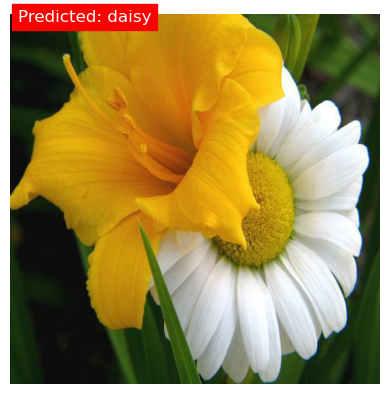

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()